In [1]:
import os
import lightgbm
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.stats import spearmanr

In [2]:
EDA_PLOTS = False

#### 20-21 Season

In [3]:
datapath = '../data/clean_data/windowed_data/'
teampath = '../data/clean_data/master_team_list.csv'
fixturepath = '../data/fixtures/full_fixture_difficulty.csv'
window_size = '9'
season = '2020-21'
pos_arr = np.array(['GK', 'DEF', 'FWD', 'MID'])

team_name_df = pd.read_csv(teampath)
fixture_df = pd.read_csv(fixturepath)
team_name_df = team_name_df[team_name_df.season == season]
fixture_df = fixture_df[fixture_df.season.str[-2:] == season[-2:]]
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_a', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'team_h', 'team_name']]
fixture_df.rename(columns={'team_name':'away_team_name'}, inplace=True)
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_h', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'away_team_name', 'team_name']]
fixture_df.rename(columns={'team_name':'home_team_name'}, inplace=True)

def attach_difficulty(row):
    '''Add the difficulty_gap column, select values based on whether the player is home/away.'''
    try:
        if row['was_home']:
            team = fixture_df[(fixture_df.home_team_name == row.team) & (fixture_df.away_team_name == row.opponent_team)].reset_index(drop=True).loc[0, 'team_h_difficulty']
            opponent = fixture_df[(fixture_df.home_team_name == row.team) & (fixture_df.away_team_name == row.opponent_team)].reset_index(drop=True).loc[0, 'team_a_difficulty']
            return team - opponent
        else:
            team = fixture_df[(fixture_df.home_team_name == row.opponent_team) & (fixture_df.away_team_name == row.team)].reset_index(drop=True).loc[0, 'team_a_difficulty']
            opponent = fixture_df[(fixture_df.home_team_name == row.opponent_team) & (fixture_df.away_team_name == row.team)].reset_index(drop=True).loc[0, 'team_h_difficulty']
            return team - opponent
    except KeyError:
        return 0

def read_data(pos, datapath, window_size, season, minimum_minutes=0):
    '''Read windowed datasets. Filter inactive players. Create bins for stratification.'''
    filename = pos + '_' + window_size
    path = os.path.join(datapath, season, filename)
    df = pd.read_csv(path + '.csv', usecols=lambda x: x != "ict_index")
    df = df[df.minutes >= minimum_minutes]
    df['difficulty_gap'] = df.apply(lambda r: attach_difficulty(r), axis=1, result_type='expand')
    df.drop(['team', 'opponent_team'], axis=1, inplace=True)
    
    df['total_points_bin'] = pd.qcut(df['Target_Output'], 4, labels=False)
    return df

dfs_20_21 = [read_data(p, datapath, window_size, season, minimum_minutes=1e-6) for p in pos_arr]
if EDA_PLOTS:
    full_df_20_21 = pd.concat(dfs_20_21, keys=pos_arr)
else:
    full_df_20_21 = pd.concat(dfs_20_21)

#### 21-22 season

In [4]:
season = '2021-22'

team_name_df = pd.read_csv(teampath)
team_name_df = team_name_df[team_name_df.season == season].drop(columns={'team_difficulty'})
fixture_df = pd.read_csv(fixturepath)
fixture_df = fixture_df[fixture_df.season.str[-2:] == season[-2:]]
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_a', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'team_h', 'team_name']]
fixture_df.rename(columns={'team_name':'away_team_name'}, inplace=True)
fixture_df = fixture_df.merge(team_name_df, how='left', left_on='team_h', right_on='team')[['team_a_difficulty', 'team_h_difficulty', 'away_team_name', 'team_name']]
fixture_df.rename(columns={'team_name':'home_team_name'}, inplace=True)

dfs_21_22 = [read_data(p, datapath, window_size, season, minimum_minutes=1e-6) for p in pos_arr]
if EDA_PLOTS:
    full_df_21_22 = pd.concat(dfs_21_22, keys=pos_arr)
else:
    full_df_21_22 = pd.concat(dfs_21_22)

In [5]:
# Combine 2 seasons
dfs = [pd.concat([dfs_20_21[i], dfs_21_22[i]]) for i in range(4)]
full_df = pd.concat([full_df_20_21, full_df_21_22])

In [6]:
full_df.columns

Index(['assists', 'clean_sheets', 'creativity', 'bps', 'goals_conceded',
       'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'saves', 'threat', 'yellow_cards',
       'total_points', 'was_home', 'Target_Output', 'difficulty_gap',
       'total_points_bin'],
      dtype='object')

In [7]:
full_df.head()

,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,yellow_cards,total_points,was_home,Target_Output,difficulty_gap,total_points_bin
0,0.0,0.0,1.111111,16.222222,1.666667,0.0,25.844444,90.0,0.0,0.0,0.0,0.0,4.0,0.222222,0.0,2.444444,False,3.0,0,2
1,0.0,0.0,1.000000,16.400000,1.600000,0.0,26.780000,90.0,0.0,0.0,0.0,0.0,4.1,0.200000,0.0,2.500000,True,1.0,-2,1
2,0.0,0.0,1.000000,16.500000,1.600000,0.0,26.680000,90.0,0.0,0.0,0.0,0.0,4.1,0.400000,0.0,2.500000,False,2.0,0,1
3,0.0,0.0,1.000000,17.500000,1.800000,0.0,28.060000,90.0,0.0,0.0,0.0,0.0,4.3,0.400000,0.0,2.500000,True,2.0,-2,1
4,0.0,0.0,0.000000,16.400000,2.000000,0.0,26.520000,90.0,0.0,0.0,0.0,0.0,4.0,0.400000,0.0,2.300000,False,2.0,-1,1


#### Plot: point distribution by position

In [8]:
if EDA_PLOTS:
    sns.set(font_scale=1.3)
    plot = sns.displot(
        data=full_df.reset_index().rename(columns={'level_0': 'position'}), 
        x="Target_Output",
        hue='position',
        kind='kde',
        common_norm=False,
        height=4.27, aspect=17.7/8.27)
    sns.move_legend(plot, "upper right", bbox_to_anchor=(.75, 0.8))

    #plot.figure.savefig('eda_pos_dist.png',dpi=600)

#### Plot: correlations

<AxesSubplot:>

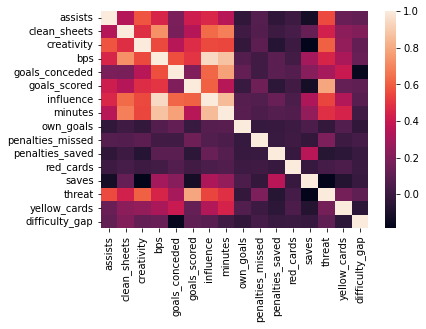

In [9]:
corr = dfs[2].drop(columns={'Target_Output', 'total_points', 'total_points_bin'}).select_dtypes('number').corr()
sns.heatmap(corr)

### Modeling

In [10]:
def get_results(data, run_lgbm=True):
    results = {}
    print('Starting...')
    
    param_grid = {
        'boosting_type': ['gbdt'],
        'objective': ['regression'],
        'n_estimators': [50, 200],
        'num_leaves': [7, 15, 31],
        'reg_alpha': [0.01, 10],
        'reg_lambda': [10, 100],
        'min_data_in_leaf': [70, 210],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.1, 0.01],
        'verbose': [-1]
    }
    if not run_lgbm:
        param_grid = {'verbose': [-1]}
    
    data = pd.get_dummies(data)
    X = data.drop('Target_Output', axis=1)
    y = data.Target_Output

    # Test set is still held-out and won't be used until writing the report.
    # Stratified split (by binned minutes)
    split_criteria_name = 'total_points_bin'
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=0, 
        stratify=X[split_criteria_name]
    )
    split_criteria = X_train[split_criteria_name]
    X_train.drop(split_criteria_name, axis=1, inplace=True)
    X_test.drop(split_criteria_name, axis=1, inplace=True)
    
    #splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    splitter = StratifiedKFold(n_splits=5)
    
    # Grid Search for lightgbm
    # Stratified cv (by binned minutes)
    grid = GridSearchCV(
        lightgbm.LGBMRegressor(random_state=0), 
        param_grid, 
        scoring='neg_mean_squared_error',
        cv=splitter.split(X_train, split_criteria),
        return_train_score=True,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_in_grid = grid.best_estimator_
    results['lgbm_est'] = best_in_grid
    results['lgbm_full_stats'] = grid.cv_results_
    
    results['lgbm_report'] = [-grid.cv_results_['mean_train_score'][grid.cv_results_['mean_test_score'].argmax()],
        grid.cv_results_['std_train_score'][grid.cv_results_['mean_test_score'].argmax()],
        -grid.cv_results_['mean_test_score'].max(),
        grid.cv_results_['std_test_score'][grid.cv_results_['mean_test_score'].argmax()], 
                              mean_squared_error(y_test, best_in_grid.predict(X_test))]
    results['lgbm_test_set'] = [X_test, y_test, best_in_grid.predict(X_test)]
    results['lgbm_spearmanr'] = spearmanr(y_test, best_in_grid.predict(X_test))
    
    # Linear Model
    scaler = StandardScaler()
    X_train_columns = X_train.columns
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lrgrid = GridSearchCV(
        linear_model.Ridge(), 
        {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
        #{'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]},
        scoring='neg_mean_squared_error',
        cv=splitter.split(X_train, split_criteria),
        return_train_score=True,
        verbose=1
    )
    lrgrid.fit(X_train, y_train)
    print('Best LR reg strength:', lrgrid.best_params_)
    best_in_grid = lrgrid.best_estimator_
    results['lr_est'] = best_in_grid
    results['lr_coef'] = pd.concat([pd.DataFrame(X_train_columns),pd.DataFrame(np.transpose(best_in_grid.coef_))], axis = 1)
    results['lr_full_stats'] = lrgrid.cv_results_
    
    results['lr_report'] = [
        -lrgrid.cv_results_['mean_train_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        lrgrid.cv_results_['std_train_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        -lrgrid.cv_results_['mean_test_score'].max(),
        lrgrid.cv_results_['std_test_score'][lrgrid.cv_results_['mean_test_score'].argmax()],
        mean_squared_error(y_test, best_in_grid.predict(X_test))
    ]
    results['lr_test_set'] = [X_test, y_test, best_in_grid.predict(X_test)]
    results['lr_spearmanr'] = spearmanr(y_test, best_in_grid.predict(X_test))
    
    return results

In [32]:
RUN_LGBM = True

def_results = get_results(dfs[1], run_lgbm=RUN_LGBM)
gk_results = get_results(dfs[0], run_lgbm=RUN_LGBM)
fwd_results = get_results(dfs[2], run_lgbm=RUN_LGBM)
mid_results = get_results(dfs[3], run_lgbm=RUN_LGBM)

Starting...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best LR reg strength: {'alpha': 100}
Starting...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best LR reg strength: {'alpha': 100}
Starting...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best LR reg strength: {'alpha': 100}
Starting...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best LR reg strength: {'alpha': 100}


#### Display Result Tables

In [33]:
report_table = {'GK': gk_results['lgbm_report'] + gk_results['lr_report'],
                'DEF': def_results['lgbm_report'] + def_results['lr_report'], 
                'MID': mid_results['lgbm_report'] + mid_results['lr_report'], 
                'FWD': fwd_results['lgbm_report'] + fwd_results['lr_report']}
col_map = {0:'lgbm_train_avg_mse', 1:'lgbm_train_mse_std', 2: 'lgbm_valid_avg_mse', 3: 'lgbm_valid_mse_std',
          4: 'lgbm_TEST_mse', 5: 'lr_train_avg_mse', 6: 'lr_train_mse_std', 7: 'lr_valid_avg_mse', 8: 'lr_valid_mse_std',
          9: 'lr_TEST_mse'}
report_table = pd.DataFrame.from_dict(report_table, orient='index').rename(columns=col_map)

In [34]:
report_table.iloc[:, :5]

,lgbm_train_avg_mse,lgbm_train_mse_std,lgbm_valid_avg_mse,lgbm_valid_mse_std,lgbm_TEST_mse
GK,6.180893,0.220380,6.666057,0.876159,6.263297
DEF,6.638182,0.112991,7.106344,0.475282,7.176953
MID,5.923685,0.050537,6.176478,0.239427,6.120561
FWD,6.554150,0.035234,6.744192,0.109267,7.251580


In [35]:
report_table.iloc[:, 5:]

,lr_train_avg_mse,lr_train_mse_std,lr_valid_avg_mse,lr_valid_mse_std,lr_TEST_mse
GK,6.574704,0.221024,6.689274,0.906006,6.481949
DEF,7.117093,0.127671,7.143748,0.507358,7.207763
MID,6.110185,0.052548,6.149452,0.211447,6.096732
FWD,6.754653,0.026028,6.780892,0.104433,7.198800


#### Plot: hyperparameter tuning to mitigate overfitting - lgbm

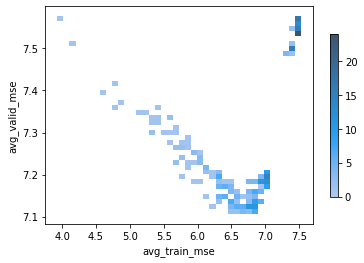

In [36]:
def lgbm_overfit_plot(res):
    overfit = {
        'avg_train_mse': -res['lgbm_full_stats']['mean_train_score'],
        'avg_valid_mse': -res['lgbm_full_stats']['mean_test_score']
    }
    overfit = pd.DataFrame.from_dict(overfit)

    plot = sns.histplot(
        overfit, x='avg_train_mse', y='avg_valid_mse',
        bins=40, cbar=True, cbar_kws=dict(shrink=.75),
    )
    #.set_title('Hyperparameter Tuning to Prevent Overfit\nGradient Boosting - Midfielders')
    return plot

plot = lgbm_overfit_plot(def_results)
plot.figure.savefig('overfit_lgbm.png',dpi=600)

#### \!\!\! No longer a good visualization
#### Plot: hyperparameter tuning to mitigate overfitting - lr

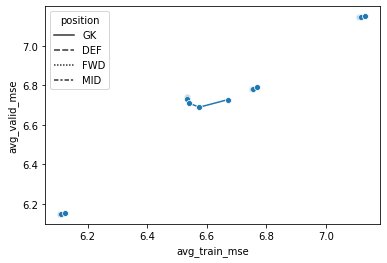

In [37]:
def lr_overfit_plot(res_lst, name_lst):
    overfit = pd.DataFrame()
    for i, res in enumerate(res_lst):
        temp = {
            'avg_train_mse': -res['lr_full_stats']['mean_train_score'],
            'avg_valid_mse': -res['lr_full_stats']['mean_test_score']
        }
        temp = pd.DataFrame.from_dict(temp)
        #temp['normalized_avg_train_mse'] = MinMaxScaler().fit_transform(np.array(temp['avg_train_mse']).reshape(-1,1))
        #temp['normalized_avg_valid_mse'] = MinMaxScaler().fit_transform(np.array(temp['avg_valid_mse']).reshape(-1,1))
        temp['position'] = name_lst[i]
        overfit = pd.concat([overfit, temp], ignore_index=True)
    
    plot = sns.lineplot(
        data=overfit, x='avg_train_mse', y='avg_valid_mse', style='position',
        marker='o', palette="flare"
    )
    #.set_title('Hyperparameter Tuning to Prevent Overfit\n Ridge Regression - All Positions')
    return plot
    

plot = lr_overfit_plot([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])
plot.figure.savefig('output_figure.png',dpi=600)

#### Confirm that Stratified Splits are working as intended

In [38]:
def check_distribution(res_lst):
    for i, res in enumerate(res_lst):
        test_y = res['lgbm_test_set'][1]
        print('Based on average score')
        print('test std:', test_y.std(), 'full std:', dfs[i].Target_Output.std())
        print('test mean:', test_y.mean(), 'full mean:', dfs[i].Target_Output.mean())

check_distribution([gk_results, def_results, fwd_results, mid_results])

Based on average score
test std: 2.8115682868826886 full std: 2.8867907975959826
test mean: 2.4803625377643503 full mean: 2.488808227465215
Based on average score
test std: 2.860807436015175 full std: 2.8431751306194806
test mean: 1.809414466130884 full mean: 1.8035837353549276
Based on average score
test std: 2.9058464739960828 full std: 2.8329078660845486
test mean: 1.8970536031238907 full mean: 1.8773698785770077
Based on average score
test std: 2.704990719138059 full std: 2.7166155854003753
test mean: 1.8807886290692344 full mean: 1.8717102246675836


#### Plot: residuals

In [39]:
# TODO: put the column names back before adding the test data to the return dictionary
'''
def test_analysis(res_lst, pos_lst):
    full_test_res = pd.DataFrame()
    for i, res in enumerate(res_lst):
        # test_res has no column name
        test_res = res['lr_test_set'][0].copy()
        
        test_res['y_true'] = res['lr_test_set'][1].reset_index(drop=True)
        test_res['y_pred'] = res['lr_test_set'][2]
        test_res['error'] = np.abs(test_res['y_pred'] - test_res['y_true'])
        test_res['pos'] = 'model'
        full_test_res = pd.concat([full_test_res, test_res])
        
    plot = sns.scatterplot(data=full_test_res, x='error', y='y_true', alpha=0.1)
    plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), color='green')
    plot.figure.savefig('some_error.png',dpi=600)

test_analysis([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])
'''

"\ndef test_analysis(res_lst, pos_lst):\n    full_test_res = pd.DataFrame()\n    for i, res in enumerate(res_lst):\n        # test_res has no column name\n        test_res = res['lr_test_set'][0].copy()\n        \n        test_res['y_true'] = res['lr_test_set'][1].reset_index(drop=True)\n        test_res['y_pred'] = res['lr_test_set'][2]\n        test_res['error'] = np.abs(test_res['y_pred'] - test_res['y_true'])\n        test_res['pos'] = 'model'\n        full_test_res = pd.concat([full_test_res, test_res])\n        \n    plot = sns.scatterplot(data=full_test_res, x='error', y='y_true', alpha=0.1)\n    plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20, 100), color='green')\n    plot.figure.savefig('some_error.png',dpi=600)\n\ntest_analysis([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])\n"

#### Check Best Params, Feature Importance, Coefficients

In [40]:
mid_results['lgbm_est'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'num_leaves': 15,
 'objective': 'regression',
 'random_state': 0,
 'reg_alpha': 10,
 'reg_lambda': 100,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'min_data_in_leaf': 70,
 'verbose': -1}

#### LightGBM built-in importance plots

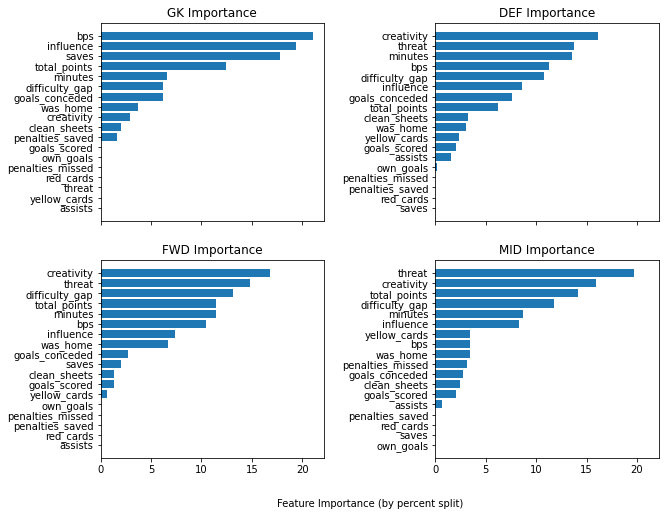

In [76]:
def lgbm_importance_grid(res_lst, pos_lst):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axs = axs.ravel()
    for i in range(len(pos_lst)):
        feature_importances = (res_lst[i]['lgbm_est'].feature_importances_ / sum(res_lst[i]['lgbm_est'].feature_importances_)) * 100
        results = pd.DataFrame({'Feature Name': res_lst[i]['lgbm_est'].feature_name_, 'Importances (Percent Split)': feature_importances})
        results.sort_values(by='Importances (Percent Split)', inplace=True)

        axs[i].barh(results['Feature Name'], results['Importances (Percent Split)'])
        axs[i].set_title(pos_lst[i] + ' Importance')
        
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)
    fig.text(0.5, 0.04, 'Feature Importance (by percent split)', ha='center')
    fig.savefig('lgbm_importance.png',dpi=800, bbox_inches="tight")

lgbm_importance_grid([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])

#### SHAP plots

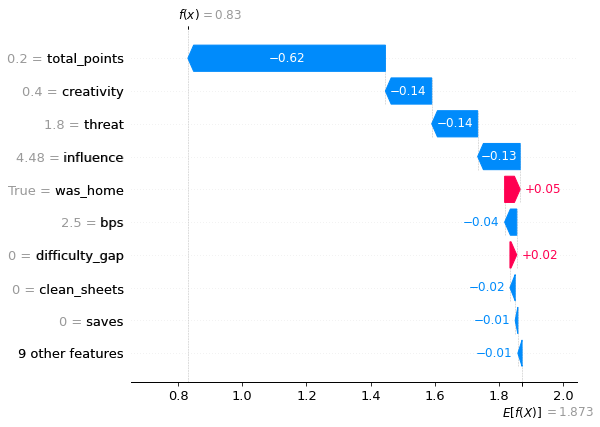

In [42]:
explainer = shap.Explainer(fwd_results['lgbm_est'])
shap_values = explainer(fwd_results['lgbm_test_set'][0])
shap.plots.waterfall(shap_values[41], show=False)
f = plt.gcf()
#f.savefig('fwd_shap_viz.png',dpi=600)

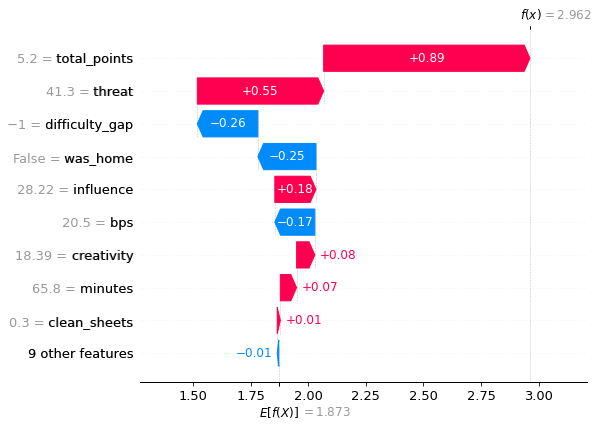

In [77]:
explainer = shap.Explainer(fwd_results['lgbm_est'])
shap_values = explainer(fwd_results['lgbm_test_set'][0])
shap.plots.waterfall(shap_values[47], show=False)
f = plt.gcf()
f.savefig('fwd_shap_viz.png',dpi=800, bbox_inches="tight")

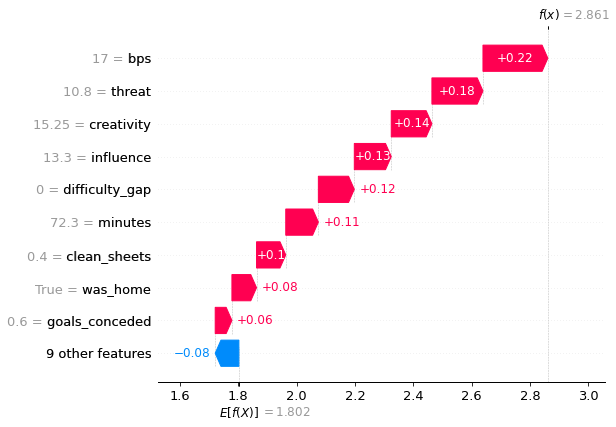

In [72]:
explainer = shap.Explainer(def_results['lgbm_est'])
shap_values = explainer(def_results['lgbm_test_set'][0])
shap.plots.waterfall(shap_values[78])

#### LR Coefs

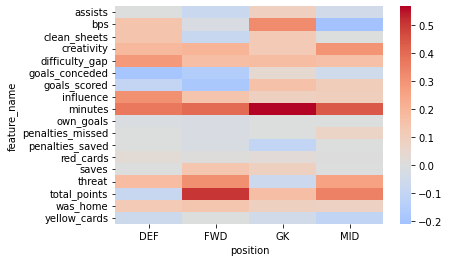

In [75]:
def show_coef_heatmap(res_lst, pos_lst):
    full_coef_df = pd.DataFrame()
    for i, res in enumerate(res_lst):
        coef_df = res['lr_coef'].copy()
        coef_df.columns = ['feature_name', 'coef']
        coef_df['position'] = pos_lst[i]
        full_coef_df = pd.concat([full_coef_df, coef_df])
    
    full_coef_df = full_coef_df.pivot(index='feature_name', columns='position', values='coef')
    plot = sns.heatmap(full_coef_df, center=0, cmap="coolwarm")
    return plot

plot = show_coef_heatmap([gk_results, def_results, fwd_results, mid_results], ['GK', 'DEF', 'FWD', 'MID'])
plot.figure.savefig('lr_coef_heatmap.png',dpi=800, bbox_inches="tight")

In [46]:
def_results['lr_coef'].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,yellow_cards,total_points,was_home,difficulty_gap
0,0.000686,0.143091,0.18306,0.143058,-0.193624,-0.099092,0.308689,0.371398,-0.013815,0.0,0.0,0.024896,0.0,0.174111,-0.068013,-0.086354,0.116687,0.282109


In [47]:
mid_results['lr_coef'].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,yellow_cards,total_points,was_home,difficulty_gap
0,-0.048041,0.001114,0.29767,-0.211026,-0.053244,0.099935,0.097166,0.440465,-0.003123,0.069936,0.0,0.003773,0.0,0.257702,-0.108205,0.347027,0.083209,0.157385


In [48]:
gk_results['lr_coef'].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,assists,clean_sheets,creativity,bps,goals_conceded,goals_scored,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,yellow_cards,total_points,was_home,difficulty_gap
0,0.092309,0.120125,0.11864,0.322823,0.039029,0.151303,0.088088,0.567363,0.000465,0.0,-0.102478,0.021215,0.088428,-0.07378,-0.049762,0.165499,0.089757,0.170994


#### Spearman's Rho

In [49]:
print(fwd_results['lr_spearmanr'], '\n', fwd_results['lgbm_spearmanr'])

SpearmanrResult(correlation=0.47823310421902493, pvalue=5.732884734753084e-161) 
 SpearmanrResult(correlation=0.4808043175406962, pvalue=6.289850229874846e-163)


In [50]:
print(def_results['lr_spearmanr'], '\n', def_results['lgbm_spearmanr'])

SpearmanrResult(correlation=0.40417184946457047, pvalue=1.9261190893721321e-69) 
 SpearmanrResult(correlation=0.40315588834378724, pvalue=4.5290042504022153e-69)


In [51]:
print(gk_results['lr_spearmanr'], '\n', gk_results['lgbm_spearmanr'])

SpearmanrResult(correlation=0.5007818240188985, pvalue=2.0536940534329786e-22) 
 SpearmanrResult(correlation=0.5321918512575002, pvalue=1.3299867044210251e-25)


In [52]:
print(mid_results['lr_spearmanr'], '\n', mid_results['lgbm_spearmanr'])

SpearmanrResult(correlation=0.49556905066269913, pvalue=1.553014029908609e-135) 
 SpearmanrResult(correlation=0.49466627664503404, pvalue=5.653531297937754e-135)
